In [1]:
# Utilities
import operator
from functools import reduce
from typing import Annotated, List, Dict, TypedDict, Literal, Optional, Callable, Set, Tuple, Any, Union, TypeVar
from datetime import datetime, timezone, timedelta
import asyncio
from pydantic import BaseModel, Field
from operator import add
from IPython.display import Image, display
import json
import re
import os
from openai import OpenAI, AsyncOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, Graph, END, START
from rich.console import Console
from rich.markdown import Markdown
from rich.panel import Panel
from rich.text import Text
from rich import box
from rich.style import Style
from dotenv import load_dotenv

In [2]:
NEMOTRON_4_340B_INSTRUCT_KEY = os.getenv("NEMOTRON_4_340B_INSTRUCT_KEY")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [3]:
def configure_api_keys():
    """Configure and verify API keys for LLM services."""

    load_dotenv()
    api_key = os.getenv("NEMOTRON_4_340B_INSTRUCT_KEY")

    is_configured = bool(os.getenv("NEMOTRON_4_340B_INSTRUCT_KEY"))
    print(f"API Key configured: {is_configured}")
    return is_configured

api_configured = configure_api_keys()
if not api_configured:
    print("\nAPI key not found. Please ensure you have:")
    print("1. Created a .env file with NEMOTRON_4_340B_INSTRUCT_KEY")

API Key configured: True


In [4]:
T = TypeVar('T')

def dict_reducer(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    """
    Merge two dictionaries recursively

    Example:
    dict1 = {"a": {"x": 1}, "b": 2}
    dict2 = {"a": {"y": 2}, "c": 3}
    result = {"a": {"x": 1, "y": 2}, "b": 2, "c": 3}
    """
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = dict_reducer(merged[key], value)
        else:
            merged[key] = value
    return merged

In [5]:
class AcademicState(TypedDict):
    """Master state container for the academic assistance system"""
    #  messages: Annotated[List[BaseMessage], add]   # Conversation history
    #  profile: dict                                 # Student information
    #  calendar: dict                                # Scheduled events
    #  tasks: dict                                   # To-do items and assignments
    #  results: Dict[str, Any]                       # Operation outputs
    messages: Annotated[List[BaseMessage], add]   # Conversation history
    profile: Annotated[Dict, dict_reducer]                 # Student information
    calendar: Annotated[Dict, dict_reducer]                # Scheduled events
    tasks: Annotated[Dict, dict_reducer]                   # To-do items and assignments
    results: Annotated[Dict[str, Any], dict_reducer]       # Operation outputs

In [6]:
class LLMConfig:
    """Configuration settings for the LLM."""
    base_url: str = "https://integrate.api.nvidia.com/v1"
    model: str = "nvidia/nemotron-4-340b-instruct"
    max_tokens: int = 1024
    default_temp: float = 0.5

class NeMoLLaMa:
  """
  A class to interact with NVIDIA's nemotron-4-340b-instruct model through their API
  This implementation uses AsyncOpenAI client for asynchronous operations
  """

  def __init__(self, api_key: str):
    """Initialize NeMoLLaMa with API key.

    Args:
        api_key (str): NVIDIA API authentication key
    """
    self.config = LLMConfig()
    self.client = AsyncOpenAI(
        base_url=self.config.base_url,
        api_key=api_key
    )
    self._is_authenticated = False

  async def check_auth(self) -> bool:
      """Verify API authentication with test request.

      Returns:
          bool: Authentication status

      Example:
          >>> is_valid = await llm.check_auth()
          >>> print(f"Authenticated: {is_valid}")
      """
      test_message = [{"role": "user", "content": "test"}]
      try:
          await self.agenerate(test_message, temperature=0.1)
          self._is_authenticated = True
          return True
      except Exception as e:
          print(f"❌ Authentication failed: {str(e)}")
          return False

  async def agenerate(
      self,
      messages: List[Dict],
      temperature: Optional[float] = None
  ) -> str:
      """Generate text using NeMo LLaMa model.

      Args:
          messages: List of message dicts with 'role' and 'content'
          temperature: Sampling temperature (0.0 to 1.0, default from config)

      Returns:
          str: Generated text response

      Example:
          >>> messages = [
          ...     {"role": "system", "content": "You are a helpful assistant"},
          ...     {"role": "user", "content": "Plan my study schedule"}
          ... ]
          >>> response = await llm.agenerate(messages, temperature=0.7)
      """
      completion = await self.client.chat.completions.create(
          model=self.config.model,
          messages=messages,
          temperature=temperature or self.config.default_temp,
          max_tokens=self.config.max_tokens,
          stream=False
      )
      return completion.choices[0].message.content

In [7]:
class DataManager:

    def __init__(self):
        """
        Initialize data storage containers.
        All data sources start as None until explicitly loaded through load_data().
        """
        self.profile_data = None
        self.calendar_data = None
        self.task_data = None

    def load_data(self, profile_json: str, calendar_json: str, task_json: str):
        """
        Load and parse multiple JSON data sources simultaneously.

        Args:
            profile_json (str): JSON string containing user profile information
            calendar_json (str): JSON string containing calendar events
            task_json (str): JSON string containing task/todo items

        Note: This method expects valid JSON strings. Any parsing errors will propagate up.
        """
        self.profile_data = profile_json
        self.calendar_data = calendar_json
        self.task_data = task_json

    def get_student_profile(self, student_id: str) -> Dict:
        """
        Retrieve a specific student's profile using their unique identifier.

        Args:
            student_id (str): Unique identifier for the student

        Returns:
            Dict: Student profile data if found, None otherwise

        Implementation Note:
            Uses generator expression with next() for efficient search through profiles,
            avoiding full list iteration when possible.
        """
        if self.profile_data:
            return next((p for p in self.profile_data["profiles"] if p["student_id"] == student_id), None)

        return None

    def parse_datetime(self, dt_str: str) -> datetime:
        """
        Smart datetime parser that handles multiple formats and ensures UTC timezone.

        Args:
            dt_str (str): DateTime string in ISO format, with or without timezone

        Returns:
            datetime: Parsed datetime object in UTC timezone

        Implementation Note:
            Handles both timezone-aware and naive datetime strings by:
            1. First attempting to parse with timezone information
            2. Falling back to assuming UTC if no timezone is specified
        """
        try:
            # First attempt: Parse ISO format with timezone
            dt = datetime.fromisoformat(dt_str.replace('Z', '+00:00'))
            return dt.astimezone(timezone.utc)
        except ValueError:
            # Fallback: Assume UTC if no timezone provided
            dt = datetime.fromisoformat(dt_str)
            return dt.replace(tzinfo=timezone.utc)

    def get_upcoming_events(self, days: int = 7) -> List[Dict]:
        """
        Intelligently filter and retrieve upcoming calendar events within a specified timeframe.

        Args:
            days (int): Number of days to look ahead (default: 7)

        Returns:
            List[Dict]: List of upcoming events, chronologically ordered

        Implementation Note:
            - Uses UTC timestamps for consistent timezone handling
            - Implements error handling for malformed event data
            - Only includes events that start in the future up to the specified timeframe
        """
        if not self.calendar_data:
            return []

        now = datetime.now(timezone.utc)
        future = now + timedelta(days=days)

        events = []
        for event in self.calendar_data.get("events", []):
            try:
                start_time = self.parse_datetime(event["start"]["dateTime"])

                if now <= start_time <= future:
                    events.append(event)
            except (KeyError, ValueError) as e:
                print(f"Warning: Could not process event due to {str(e)}")
                continue

        return events

    def get_active_tasks(self) -> List[Dict]:
        """
        Retrieve and filter active tasks, enriching them with parsed datetime information.

        Returns:
            List[Dict]: List of active tasks with parsed due dates

        Implementation Note:
            - Filters for tasks that are:
              1. Not completed ("needsAction" status)
              2. Due in the future
            - Enriches task objects with parsed datetime for easier processing
            - Implements robust error handling for malformed task data
        """
        if not self.task_data:
            return []

        now = datetime.now(timezone.utc)
        active_tasks = []

        for task in self.task_data.get("tasks", []):
            try:
                due_date = self.parse_datetime(task["due"])
                if task["status"] == "needsAction" and due_date > now:
                    # Enrich task object with parsed datetime
                    task["due_datetime"] = due_date
                    active_tasks.append(task)
            except (KeyError, ValueError) as e:
                print(f"Warning: Could not process task due to {str(e)}")
                continue

        return active_tasks

In [8]:
llm = NeMoLLaMa(NEMOTRON_4_340B_INSTRUCT_KEY)
data_manager = DataManager()
print(llm)

In [9]:
class AgentExecutor:


    def __init__(self, llm):
        """
        Initialize the executor with a language model and create agent instances.

        Args:
            llm: Language model instance to be used by all agents

        Implementation Note:
            - Creates a dictionary of specialized agents, each initialized with the same LLM
            - Supports multiple agent types: PLANNER (default), NOTEWRITER, and ADVISOR
            - Agents are instantiated once and reused across executions
        """
        self.llm = llm
        self.agents = {
            "PLANNER": PlannerAgent(llm),      # Strategic planning agent
            "NOTEWRITER": NoteWriterAgent(llm), # Documentation agent
            "ADVISOR": AdvisorAgent(llm)        # Academic advice agent
        }

    async def execute(self, state: AcademicState) -> Dict:
        """
        Orchestrates concurrent execution of multiple AI agents based on analysis results.

        This method implements a sophisticated execution pattern:
        1. Reads coordination analysis to determine required agents
        2. Groups agents for concurrent execution
        3. Executes agent groups in parallel
        4. Handles failures gracefully with fallback mechanisms

        Args:
            state (AcademicState): Current academic state containing analysis results

        Returns:
            Dict: Consolidated results from all executed agents

        Implementation Details:
        ---------------------
        1. Analysis Interpretation:
           - Extracts coordination analysis from state
           - Determines required agents and their concurrent execution groups

        2. Concurrent Execution Pattern:
           - Processes agents in groups that can run in parallel
           - Uses asyncio.gather() for concurrent execution within each group
           - Only executes agents that are both required and available

        3. Result Management:
           - Collects and processes results from each concurrent group
           - Filters out failed executions (exceptions)
           - Formats successful results into a structured output

        4. Fallback Mechanisms:
           - If no results are gathered, falls back to PLANNER agent
           - Provides emergency fallback plan in case of complete failure

        Error Handling:
        --------------
        - Catches and handles exceptions at multiple levels:
          * Individual agent execution failures don't affect other agents
          * System-level failures trigger emergency fallback
        - Maintains system stability through graceful degradation
        """
        try:
            # Extract coordination analysis from state
            analysis = state["results"].get("coordinator_analysis", {})

            # Determine execution requirements
            required_agents = analysis.get("required_agents", ["PLANNER"])  # PLANNER as default
            concurrent_groups = analysis.get("concurrent_groups", [])       # Groups for parallel execution

            # Initialize results container
            results = {}

            # Process each concurrent group sequentially
            for group in concurrent_groups:
                # Prepare concurrent tasks for current group
                tasks = []
                for agent_name in group:
                    # Validate agent availability and requirement
                    if agent_name in required_agents and agent_name in self.agents:
                        tasks.append(self.agents[agent_name](state))

                # Execute group tasks concurrently if any exist
                if tasks:
                    # Gather results from concurrent execution
                    group_results = await asyncio.gather(*tasks, return_exceptions=True)

                    # Process successful results only
                    for agent_name, result in zip(group, group_results):
                        if not isinstance(result, Exception):
                            results[agent_name.lower()] = result

            # Implement fallback strategy if no results were obtained
            if not results and "PLANNER" in self.agents:
                planner_result = await self.agents["PLANNER"](state)
                results["planner"] = planner_result

            print("agent_outputs", results)

            # Return structured results
            return {
                "results": {
                    "agent_outputs": results
                }
            }

        except Exception as e:
            print(f"Execution error: {e}")
            # Emergency fallback with minimal response
            return {
                "results": {
                    "agent_outputs": {
                        "planner": {
                            "plan": "Emergency fallback plan: Please try again or contact support."
                        }
                    }
                }
            }

In [10]:
class AgentAction(BaseModel):
   """
   Model representing an agent's action decision.

   Attributes:
       action (str): The specific action to be taken (e.g., "search_calendar", "analyze_tasks")
       thought (str): The reasoning process behind the action choice
       tool (Optional[str]): The specific tool to be used for the action (if needed)
       action_input (Optional[Dict]): Input parameters for the action

   Example:
       >>> action = AgentAction(
       ...     action="search_calendar",
       ...     thought="Need to check schedule conflicts",
       ...     tool="calendar_search",
       ...     action_input={"date_range": "next_week"}
       ... )
   """
   action: str      # Required action to be performed
   thought: str     # Reasoning behind the action
   tool: Optional[str] = None        # Optional tool specification
   action_input: Optional[Dict] = None  # Optional input parameters

class AgentOutput(BaseModel):
   """
   Model representing the output from an agent's action.

   Attributes:
       observation (str): The result or observation from executing the action
       output (Dict): Structured output data from the action

   Example:
       >>> output = AgentOutput(
       ...     observation="Found 3 free time slots next week",
       ...     output={
       ...         "free_slots": ["Mon 2PM", "Wed 10AM", "Fri 3PM"],
       ...         "conflicts": []
       ...     }
       ... )
   """
   observation: str  # Result or observation from the action
   output: Dict     # Structured output data

In [11]:
class ReActAgent:
  """
    Base class for ReACT-based agents implementing reasoning and action capabilities.

    Features:
    - Tool management for specific actions
    - Few-shot learning examples
    - Structured thought process
    - Action execution framework
  """

  def __init__(self, llm):
      """
      Initialize the ReActAgent with language model and available tools

      Args:
          llm: Language model instance for agent operations
      """
      self.llm = llm
      # Storage for few-shot examples to guide the agent
      self.few_shot_examples = []

      # Dictionary of available tools with their corresponding methods
      self.tools = {
          "search_calendar": self.search_calendar,      # Calendar search functionality
          "analyze_tasks": self.analyze_tasks,          # Task analysis functionality
          "check_learning_style": self.check_learning_style,  # Learning style assessment
          "check_performance": self.check_performance   # Academic performance checking
      }

  async def search_calendar(self, state: AcademicState) -> List[Dict]:
      """
      Search for upcoming calendar events

      Args:
          state (AcademicState): Current academic state

      Returns:
          List[Dict]: List of upcoming calendar events
      """
      # Get events from calendar or empty list if none exist
      events = state["calendar"].get("events", [])
      # Get current time in UTC
      now = datetime.now(timezone.utc)
      # Filter and return only future events
      return [e for e in events if datetime.fromisoformat(e["start"]["dateTime"]) > now]

  async def analyze_tasks(self, state: AcademicState) -> List[Dict]:
      """
      Analyze academic tasks from the current state

      Args:
          state (AcademicState): Current academic state

      Returns:
          List[Dict]: List of academic tasks
      """
      # Return tasks or empty list if none exist
      return state["tasks"].get("tasks", [])

  async def check_learning_style(self, state: AcademicState) -> AcademicState:
        """
        Retrieve student's learning style and study patterns

        Args:
            state (AcademicState): Current academic state

        Returns:
            AcademicState: Updated state with learning style analysis
        """
        # Get user profile from state
        profile = state["profile"]

        # Get learning preferences
        learning_data = {
            "style": profile.get("learning_preferences", {}).get("learning_style", {}),
            "patterns": profile.get("learning_preferences", {}).get("study_patterns", {})
        }

        # Add to results in state
        if "results" not in state:
            state["results"] = {}
        state["results"]["learning_analysis"] = learning_data

        return state

  async def check_performance(self, state: AcademicState) -> AcademicState:
        """
        Check current academic performance across courses

        Args:
            state (AcademicState): Current academic state

        Returns:
            AcademicState: Updated state with performance analysis
        """
        # Get user profile from state
        profile = state["profile"]

        # Get course information
        courses = profile.get("academic_info", {}).get("current_courses", [])

        # Add to results in state
        if "results" not in state:
            state["results"] = {}
        state["results"]["performance_analysis"] = {"courses": courses}

        return state

In [12]:
async def analyze_context(state: AcademicState) -> Dict:
    """
    Analyzes the academic state context to inform coordinator decision-making.

    This function performs comprehensive context analysis by:
    1. Extracting student profile information
    2. Analyzing calendar and task loads
    3. Identifying relevant course context from the latest message
    4. Gathering learning preferences and study patterns

    Args:
        state (AcademicState): Current academic state including profile, calendar, and tasks

    Returns:
        Dict: Structured analysis of the student's context for decision making

    Implementation Notes:
    ------------------
    - Extracts information hierarchically using nested get() operations for safety
    - Identifies current course context from the latest message content
    - Provides default values for missing information to ensure stability
    """
    # Extract main data components with safe navigation
    profile = state.get("profile", {})
    calendar = state.get("calendar", {})
    tasks = state.get("tasks", {})

    # Extract course information and match with current request
    courses = profile.get("academic_info", {}).get("current_courses", [])
    current_course = None
    request = state["messages"][-1].content.lower()  # Latest message for context

    # Identify relevant course from request content
    for course in courses:
        if course["name"].lower() in request:
            current_course = course
            break

    # Construct comprehensive context analysis
    return {
        "student": {
            "major": profile.get("personal_info", {}).get("major", "Unknown"),
            "year": profile.get("personal_info", {}).get("academic_year"),
            "learning_style": profile.get("learning_preferences", {}).get("learning_style", {}),
        },
        "course": current_course,
        "upcoming_events": len(calendar.get("events", [])),  # Calendar load indicator
        "active_tasks": len(tasks.get("tasks", [])),        # Task load indicator
        "study_patterns": profile.get("learning_preferences", {}).get("study_patterns", {})
    }

def parse_coordinator_response(response: str) -> Dict:
    """
    Parses LLM coordinator response into structured analysis for agent execution.

    This function implements a robust parsing strategy:
    1. Starts with safe default configuration
    2. Analyzes ReACT patterns in the response
    3. Adjusts agent requirements and priorities based on content
    4. Organizes concurrent execution groups

    Args:
        response (str): Raw LLM response text

    Returns:
        Dict: Structured analysis containing:
            - required_agents: List of agents needed
            - priority: Priority levels for each agent
            - concurrent_groups: Groups of agents that can run together
            - reasoning: Extracted reasoning for decisions

    Implementation Notes:
    ------------------
    1. Default Configuration:
       - Always includes PLANNER agent as baseline
       - Sets basic priority and concurrent execution structure

    2. Response Analysis:
       - Looks for ReACT patterns (Thought/Decision structure)
       - Identifies agent requirements from content keywords
       - Extracts reasoning from thought section

    3. Agent Configuration:
       - NOTEWRITER triggered by note-taking related content
       - ADVISOR triggered by guidance/advice related content
       - Organizes concurrent execution groups based on dependencies

    4. Error Handling:
       - Provides fallback configuration if parsing fails
       - Maintains system stability through default values
    """
    try:
        # Initialize with safe default configuration
        analysis = {
            "required_agents": ["PLANNER"],         # PLANNER is always required
            "priority": {"PLANNER": 1},             # Base priority structure
            "concurrent_groups": [["PLANNER"]],     # Default execution group
            "reasoning": "Default coordination"      # Default reasoning
        }

        # Parse ReACT patterns for advanced coordination
        if "Thought:" in response and "Decision:" in response:
            # Check for NOTEWRITER requirements
            if "NoteWriter" in response or "note" in response.lower():
                analysis["required_agents"].append("NOTEWRITER")
                analysis["priority"]["NOTEWRITER"] = 2
                # NOTEWRITER can run concurrently with PLANNER
                analysis["concurrent_groups"] = [["PLANNER", "NOTEWRITER"]]

            # Check for ADVISOR requirements
            if "Advisor" in response or "guidance" in response.lower():
                analysis["required_agents"].append("ADVISOR")
                analysis["priority"]["ADVISOR"] = 3
                # ADVISOR typically runs after initial planning

            # Extract and store reasoning from thought section
            thought_section = response.split("Thought:")[1].split("Action:")[0].strip()
            analysis["reasoning"] = thought_section

        return analysis

    except Exception as e:
        print(f"Parse error: {str(e)}")
        # Fallback to safe default configuration
        return {
            "required_agents": ["PLANNER"],
            "priority": {"PLANNER": 1},
            "concurrent_groups": [["PLANNER"]],
            "reasoning": "Fallback due to parse error"
        }

In [13]:
COORDINATOR_PROMPT ="""You are a Coordinator Agent using ReACT framework to orchestrate multiple academic support agents.

        AVAILABLE AGENTS:
        • PLANNER: Handles scheduling and time management
        • NOTEWRITER: Creates study materials and content summaries
        • ADVISOR: Provides personalized academic guidance

        PARALLEL EXECUTION RULES:
        1. Group compatible agents that can run concurrently
        2. Maintain dependencies between agent executions
        3. Coordinate results from parallel executions

        REACT PATTERN:
        Thought: [Analyze request complexity and required support types]
        Action: [Select optimal agent combination]
        Observation: [Evaluate selected agents' capabilities]
        Decision: [Finalize agent deployment plan]

        ANALYSIS POINTS:
        1. Task Complexity and Scope
        2. Time Constraints
        3. Resource Requirements
        4. Learning Style Alignment
        5. Support Type Needed

        CONTEXT:
        Request: {request}
        Student Context: {context}

        FORMAT RESPONSE AS:
        Thought: [Analysis of academic needs and context]
        Action: [Agent selection and grouping strategy]
        Observation: [Expected workflow and dependencies]
        Decision: [Final agent deployment plan with rationale]
        """

In [14]:
async def coordinator_agent(state: AcademicState) -> Dict:
    """
    Primary coordinator agent that orchestrates multiple academic support agents using ReACT framework.

    This agent implements a sophisticated coordination strategy:
    1. Analyzes academic context and student needs
    2. Uses ReACT framework for structured decision making
    3. Coordinates parallel agent execution
    4. Handles fallback scenarios

    Args:
        state (AcademicState): Current academic state including messages and context

    Returns:
        Dict: Coordination analysis including required agents, priorities, and execution groups

    Implementation Notes:
    -------------------
    1. ReACT Framework Implementation:
       - Thought: Analysis phase
       - Action: Agent selection phase
       - Observation: Capability evaluation
       - Decision: Final execution planning

    2. Agent Coordination Strategy:
       - Manages three specialized agents:
         * PLANNER: Core scheduling agent
         * NOTEWRITER: Content creation agent
         * ADVISOR: Academic guidance agent

    3. Parallel Execution Management:
       - Groups compatible agents
       - Maintains execution dependencies
       - Coordinates parallel workflows
    """
    try:
        # Analyze current context and extract latest query
        context = await analyze_context(state)
        query = state["messages"][-1].content

        # Define the ReACT-based coordination prompt
        prompt = COORDINATOR_PROMPT

        # Generate coordination plan using LLM
        response = await llm.agenerate([
            {"role": "system", "content": prompt.format(
                request=query,
                context=json.dumps(context, indent=2)
            )}
        ])

        # Parse response and structure coordination analysis
        analysis = parse_coordinator_response(response)
        return {
            "results": {
                "coordinator_analysis": {
                    "required_agents": analysis.get("required_agents", ["PLANNER"]),
                    "priority": analysis.get("priority", {"PLANNER": 1}),
                    "concurrent_groups": analysis.get("concurrent_groups", [["PLANNER"]]),
                    "reasoning": response
                }
            }
        }

    except Exception as e:
        print(f"Coordinator error: {e}")
        # Fallback to basic planning configuration
        return {
            "results": {
                "coordinator_analysis": {
                    "required_agents": ["PLANNER"],
                    "priority": {"PLANNER": 1},
                    "concurrent_groups": [["PLANNER"]],
                    "reasoning": "Error in coordination. Falling back to planner."
                }
            }
        }

def parse_coordinator_response(response: str) -> Dict:
    """
    Parses LLM response into structured coordination analysis.

    This function:
    1. Starts with default safe configuration
    2. Analyzes ReACT pattern responses
    3. Identifies required agents and priorities
    4. Structures concurrent execution groups

    Args:
        response (str): Raw LLM response following ReACT pattern

    Returns:
        Dict: Structured analysis for agent execution

    Implementation Notes:
    -------------------
    1. Default Configuration:
       - Always includes PLANNER as base agent
       - Sets initial priority structure
       - Defines basic execution group

    2. Response Analysis:
       - Detects ReACT pattern markers
       - Identifies agent requirements
       - Determines execution priorities

    3. Agent Coordination:
       - Groups compatible agents for parallel execution
       - Sets priority levels for sequential tasks
       - Maintains execution dependencies
    """
    try:
        # Initialize with safe default configuration
        analysis = {
            "required_agents": ["PLANNER"],
            "priority": {"PLANNER": 1},
            "concurrent_groups": [["PLANNER"]],
            "reasoning": response
        }

        # Parse ReACT patterns for advanced coordination
        if "Thought:" in response and "Decision:" in response:
            # Check for NOTEWRITER requirements
            if "NOTEWRITER" in response or "note" in response.lower():
                analysis["required_agents"].append("NOTEWRITER")
                analysis["priority"]["NOTEWRITER"] = 2
                # NOTEWRITER can run parallel with PLANNER
                analysis["concurrent_groups"] = [["PLANNER", "NOTEWRITER"]]

            # Check for ADVISOR requirements
            if "ADVISOR" in response or "guidance" in response.lower():
                analysis["required_agents"].append("ADVISOR")
                analysis["priority"]["ADVISOR"] = 3
                # ADVISOR typically runs sequentially

        return analysis

    except Exception as e:
        print(f"Parse error: {str(e)}")
        # Return safe default configuration
        return {
            "required_agents": ["PLANNER"],
            "priority": {"PLANNER": 1},
            "concurrent_groups": [["PLANNER"]],
            "reasoning": "Fallback due to parse error"
        }
     

In [15]:
PROFILE_ANALYZER_PROMPT = """You are a Profile Analysis Agent using the ReACT framework to analyze student profiles.

    OBJECTIVE:
    Analyze the student profile and extract key learning patterns that will impact their academic success.

    REACT PATTERN:
    Thought: Analyze what aspects of the profile need investigation
    Action: Extract specific information from relevant profile sections
    Observation: Note key patterns and implications
    Response: Provide structured analysis

    PROFILE DATA:
    {profile}

    ANALYSIS FRAMEWORK:
    1. Learning Characteristics:
        • Primary learning style
        • Information processing patterns
        • Attention span characteristics

    2. Environmental Factors:
        • Optimal study environment
        • Distraction triggers
        • Productive time periods

    3. Executive Function:
        • Task management patterns
        • Focus duration limits
        • Break requirements

    4. Energy Management:
        • Peak energy periods
        • Recovery patterns
        • Fatigue signals

    INSTRUCTIONS:
    1. Use the ReACT pattern for each analysis area
    2. Provide specific, actionable observations
    3. Note both strengths and challenges
    4. Identify patterns that affect study planning

    FORMAT YOUR RESPONSE AS:
    Thought: [Initial analysis of profile components]
    Action: [Specific areas being examined]
    Observation: [Patterns and insights discovered]
    Analysis Summary: [Structured breakdown of key findings]
    Recommendations: [Specific adaptations needed]
    """

In [16]:
async def profile_analyzer(state: AcademicState) -> Dict:
    """
    Analyzes student profile data to extract and interpret learning preferences using ReACT framework.

    This agent specializes in:
    1. Deep analysis of student learning profiles
    2. Extraction of learning preferences and patterns
    3. Interpretation of academic history and tendencies
    4. Generation of personalized learning insights

    Args:
        state (AcademicState): Current academic state containing student profile data

    Returns:
        Dict: Structured analysis results including learning preferences and recommendations

    """
    # Extract profile data from state
    profile = state["profile"]

    # Assumes PROFILE_ANALYZER_PROMPT is defined elsewhere with ReACT framework structure
    prompt = PROFILE_ANALYZER_PROMPT

    # Construct message array for LLM interaction
    messages = [
        # System message defines analysis framework and expectations
        {"role": "system", "content": prompt},
        # User message contains serialized profile data for analysis
        {"role": "user", "content": json.dumps(profile)}
    ]

    # Generate analysis using LLM
    response = await llm.agenerate(messages)

    # Format and structure the analysis results
    return {
        "results": {
            "profile_analysis": {
                "analysis": response  # Contains structured learning preference analysis
            }
        }
    }
     

In [17]:
class PlannerAgent(ReActAgent):
    def __init__(self, llm):
        super().__init__(llm)  # Initialize parent ReActAgent class
        self.llm = llm
        # Load example scenarios to help guide the AI's responses
        self.few_shot_examples = self._initialize_fewshots()
        # Create the workflow structure
        self.workflow = self.create_subgraph()

    def _initialize_fewshots(self):
        """
        Define example scenarios to help the AI understand how to handle different situations
        Each example shows:
        - Input: The student's request
        - Thought: The analysis process
        - Action: What needs to be done
        - Observation: What was found
        - Plan: The detailed solution
        """
        return [
            {
                "input": "Help with exam prep while managing ADHD and football",
                "thought": "Need to check calendar conflicts and energy patterns",
                "action": "search_calendar",
                "observation": "Football match at 6PM, exam tomorrow 9AM",
                "plan": """ADHD-OPTIMIZED SCHEDULE:
                    PRE-FOOTBALL (2PM-5PM):
                    - 3x20min study sprints
                    - Movement breaks
                    - Quick rewards after each sprint

                    FOOTBALL MATCH (6PM-8PM):
                    - Use as dopamine reset
                    - Formula review during breaks

                    POST-MATCH (9PM-12AM):
                    - Environment: Café noise
                    - 15/5 study/break cycles
                    - Location changes hourly

                    EMERGENCY PROTOCOLS:
                    - Focus lost → jumping jacks
                    - Overwhelmed → room change
                    - Brain fog → cold shower"""
            },
            {
                "input": "Struggling with multiple deadlines",
                "thought": "Check task priorities and performance issues",
                "action": "analyze_tasks",
                "observation": "3 assignments due, lowest grade in Calculus",
                "plan": """PRIORITY SCHEDULE:
                    HIGH-FOCUS SLOTS:
                    - Morning: Calculus practice
                    - Post-workout: Assignments
                    - Night: Quick reviews

                    ADHD MANAGEMENT:
                    - Task timer challenges
                    - Reward system per completion
                    - Study buddy accountability"""
            }
        ]
    # Section 2: Create the Planning Workflow Graph and Return with compile the graph
    def create_subgraph(self) -> StateGraph:
        """
        Create a workflow graph that defines how the planner processes requests:
        1. First analyzes calendar (calendar_analyzer)
        2. Then analyzes tasks (task_analyzer)
        3. Finally generates a plan (plan_generator)
        """
        # Initialize a new graph using our AcademicState structure
        subgraph = StateGraph(AcademicState)

        # Add each processing step as a node in our graph
        subgraph.add_node("calendar_analyzer", self.calendar_analyzer)
        subgraph.add_node("task_analyzer", self.task_analyzer)
        subgraph.add_node("plan_generator", self.plan_generator)

        # Connect the nodes in the order they should execute
        subgraph.add_edge("calendar_analyzer", "task_analyzer")
        subgraph.add_edge("task_analyzer", "plan_generator")

        # Set where the workflow begins
        subgraph.set_entry_point("calendar_analyzer")

        # Prepare the graph for use
        return subgraph.compile()

    async def calendar_analyzer(self, state: AcademicState) -> AcademicState:
        """
        Analyze the student's calendar to find:
        - Available study times
        - Potential scheduling conflicts
        - Energy patterns throughout the day
        """
        # Get calendar events for the next 7 days
        events = state["calendar"].get("events", [])
        now = datetime.now(timezone.utc)
        future = now + timedelta(days=7)

        # Filter to only include upcoming events
        filtered_events = [
            event for event in events
            if now <= datetime.fromisoformat(event["start"]["dateTime"]) <= future
        ]

        # Create prompt for the AI to analyze the calendar
        prompt = """Analyze calendar events and identify:
        Events: {events}

        Focus on:
        - Available time blocks
        - Energy impact of activities
        - Potential conflicts
        - Recovery periods
        - Study opportunity windows
        - Activity patterns
        - Schedule optimization
        """

        # Ask AI to analyze the calendar
        messages = [
            {"role": "system", "content": prompt},
            {"role": "user", "content": json.dumps(filtered_events)}
        ]

        response = await self.llm.agenerate(messages)
        #cleaned_response = clean_llm_output({"response": response})

        # Return the analysis results
        return {
            "results": {
                "calendar_analysis": {
                    "analysis":response
                }
            }
        }
    async def task_analyzer(self, state: AcademicState) -> AcademicState:
        """
        Analyze tasks to determine:
        - Priority order
        - Time needed for each task
        - Best approach for completion
        """
        tasks = state["tasks"].get("tasks", [])

        # Create prompt for AI to analyze tasks
        prompt = """Analyze tasks and create priority structure:
        Tasks: {tasks}

        Consider:
        - Urgency levels
        - Task complexity
        - Energy requirements
        - Dependencies
        - Required focus levels
        - Time estimations
        - Learning objectives
        - Success criteria
        """

        messages = [
            {"role": "system", "content": prompt},
            {"role": "user", "content": json.dumps(tasks)}
        ]

        response = await self.llm.agenerate(messages)
        #cleaned_response = clean_llm_output({"response": response})

        return {
            "results": {
                "task_analysis": {
                    "analysis": response
                }
            }
        }

    async def plan_generator(self, state: AcademicState) -> AcademicState:
        """
        Create a comprehensive study plan by combining:
        - Profile analysis (student's learning style)
        - Calendar analysis (available time)
        - Task analysis (what needs to be done)
        """
        # Gather all previous analyses
        profile_analysis = state["results"]["profile_analysis"]
        calendar_analysis = state["results"]["calendar_analysis"]
        task_analysis = state["results"]["task_analysis"]

        # Create detailed prompt for AI to generate plan
        prompt = f"""AI Planning Assistant: Create focused study plan using ReACT framework.

          INPUT CONTEXT:
          - Profile Analysis: {profile_analysis}
          - Calendar Analysis: {calendar_analysis}
          - Task Analysis: {task_analysis}

          EXAMPLES:
          {json.dumps(self.few_shot_examples, indent=2)}

          INSTRUCTIONS:
          1. Follow ReACT pattern:
            Thought: Analyze situation and needs
            Action: Consider all analyses
            Observation: Synthesize findings
            Plan: Create structured plan

          2. Address:
            - ADHD management strategies
            - Energy level optimization
            - Task chunking methods
            - Focus period scheduling
            - Environment switching tactics
            - Recovery period planning
            - Social/sport activity balance

          3. Include:
            - Emergency protocols
            - Backup strategies
            - Quick wins
            - Reward system
            - Progress tracking
            - Adjustment triggers

          Pls act as an intelligent tool to help the students reach their goals or overcome struggles and answer with informal words.

          FORMAT:
          Thought: [reasoning and situation analysis]
          Action: [synthesis approach]
          Observation: [key findings]
          Plan: [actionable steps and structural schedule]
          """


        messages = [
            {"role": "system", "content": prompt},
            {"role": "user", "content": state["messages"][-1].content}
        ]
        # temperature is like a randomness of LLM response, 0.5 is in the middle
        response = await self.llm.agenerate(messages, temperature=0.5)

        # Clean the response before returning
        #cleaned_response = clean_llm_output({"response": response})

        return {
                "results": {
                    "final_plan": {
                        "plan": response
                    }
                }
        }

    async def __call__(self, state: AcademicState) -> Dict:
        """
        Main execution method that runs the entire planning workflow:
        1. Analyze calendar
        2. Analyze tasks
        3. Generate plan
        """
        try:
            final_state = await self.workflow.ainvoke(state)
            # Clean the generated notes before returning
            notes = final_state["results"].get("generated_notes", {})
            #cleaned_notes = clean_llm_output({"notes": notes})
            return {"notes": final_state["results"].get("generated_notes")}
            #return {"notes": cleaned_notes.get("notes")}
        except Exception as e:
            return {"notes": "Error generating notes. Please try again."}



In [18]:
class NoteWriterAgent(ReActAgent):
    """NoteWriter agent with its own subgraph workflow for note generation.
    This agent specializes in creating personalized study materials by analyzing
    learning styles and generating structured notes."""

    def __init__(self, llm):
        """Initialize the NoteWriter agent with an LLM backend and example templates.

        Args:
            llm: Language model instance for text generation
        """
        super().__init__(llm)
        self.llm = llm
        self.few_shot_examples = [
            {
                "input": "Need to cram Calculus III for tomorrow",
                "template": "Quick Review",
                "notes": """CALCULUS III ESSENTIALS:

                1. CORE CONCEPTS (80/20 Rule):
                   • Multiple Integrals → volume/area
                   • Vector Calculus → flow/force/rotation
                   • KEY FORMULAS:
                     - Triple integrals in cylindrical/spherical coords
                     - Curl, divergence, gradient relationships

                2. COMMON EXAM PATTERNS:
                   • Find critical points
                   • Calculate flux/work
                   • Optimize with constraints

                3. QUICKSTART GUIDE:
                   • Always draw 3D diagrams
                   • Check units match
                   • Use symmetry to simplify

                4. EMERGENCY TIPS:
                   • If stuck, try converting coordinates
                   • Check boundary conditions
                   • Look for special patterns"""
            }
        ]
        self.workflow = self.create_subgraph()

    def create_subgraph(self) -> StateGraph:
        """Creates NoteWriter's internal workflow as a state machine.

        The workflow consists of two main steps:
        1. Analyze learning style and content requirements
        2. Generate personalized notes

        Returns:
            StateGraph: Compiled workflow graph
        """
        subgraph = StateGraph(AcademicState)

        # Define the core workflow nodes
        subgraph.add_node("notewriter_analyze", self.analyze_learning_style)
        subgraph.add_node("notewriter_generate", self.generate_notes)

        # Create the workflow sequence:
        # START -> analyze -> generate -> END
        subgraph.add_edge(START, "notewriter_analyze")
        subgraph.add_edge("notewriter_analyze", "notewriter_generate")
        subgraph.add_edge("notewriter_generate", END)

        return subgraph.compile()

    async def analyze_learning_style(self, state: AcademicState) -> AcademicState:
        """Analyzes student profile and request to determine optimal note structure.

        Uses the LLM to analyze:
        - Student's learning style preferences
        - Specific content request
        - Time constraints and requirements

        Args:
            state: Current academic state containing student profile and messages

        Returns:
            Updated state with learning analysis results
        """
        profile = state["profile"]
        learning_style = profile["learning_preferences"]["learning_style"]
        # Construct analysis prompt with specific formatting requirements

        prompt = f"""Analyze content requirements and determine optimal note structure:

        STUDENT PROFILE:
        - Learning Style: {json.dumps(learning_style, indent=2)}
        - Request: {state['messages'][-1].content}

        FORMAT:
        1. Key Topics (80/20 principle)
        2. Learning Style Adaptations
        3. Time Management Strategy
        4. Quick Reference Format

        FOCUS ON:
        - Essential concepts that give maximum understanding
        - Visual and interactive elements
        - Time-optimized study methods
        """

        response = await self.llm.agenerate([
            {"role": "system", "content": prompt}
        ])
        #cleaned_response = clean_llm_output({"response": response})


        return {
            "results": {
                "learning_analysis": {
                    "analysis": response
                }
            }
        }

    async def generate_notes(self, state: AcademicState) -> AcademicState:
        """Generates personalized study notes based on the learning analysis.

        Uses the LLM to create structured notes that are:
        - Adapted to the student's learning style
        - Focused on essential concepts (80/20 principle)
        - Time-optimized for the study period

        Args:
            state: Current academic state with learning analysis
        Returns:
            Updated state with generated notes
        """

        analysis = state["results"].get("learning_analysis", "")
        learning_style = state["profile"]["learning_preferences"]["learning_style"]

        # Build prompt using analysis and few-shot examples
        prompt = f"""Create concise, high-impact study materials based on analysis:

        ANALYSIS: {analysis}
        LEARNING STYLE: {json.dumps(learning_style, indent=2)}
        REQUEST: {state['messages'][-1].content}

        EXAMPLES:
        {json.dumps(self.few_shot_examples, indent=2)}

        FORMAT:
        **THREE-WEEK INTENSIVE STUDY PLANNER**

        [Generate structured notes with:]
        1. Weekly breakdown
        2. Daily focus areas
        3. Core concepts
        4. Emergency tips
        """

        response = await self.llm.agenerate([
            {"role": "system", "content": prompt}
        ])
        #cleaned_response = clean_llm_output({"response": response})
        # if "results" not in state:
        #     state["results"] = {}
        # state["results"]["generated_notes"] = response
        # return state
        return {
            "results": {
                "generated_notes": {
                    "notes": response
                }
            }
        }


    async def __call__(self, state: AcademicState) -> Dict:
        """Main execution method for the NoteWriter agent.

        Executes the complete workflow:
        1. Analyzes learning requirements
        2. Generates personalized notes
        3. Cleans and returns the results

        Args:
            state: Initial academic state

        Returns:
            Dict containing generated notes or error message
        """
        try:
            final_state = await self.workflow.ainvoke(state)
            # Clean the generated notes before returning
            notes = final_state["results"].get("generated_notes", {})
            #cleaned_notes = clean_llm_output({"notes": notes})
            return {"notes": final_state["results"].get("generated_notes")}
            #return {"notes": cleaned_notes.get("notes")}
        except Exception as e:
            return {"notes": "Error generating notes. Please try again."}

In [19]:
class AdvisorAgent(ReActAgent):
    """Academic advisor agent with subgraph workflow for personalized guidance.
    This agent specializes in analyzing student situations and providing
    tailored academic advice considering learning styles and time constraints."""

    def __init__(self, llm):
        """Initialize the Advisor agent with an LLM backend and example templates.

        Args:
            llm: Language model instance for text generation
        """
        super().__init__(llm)
        self.llm = llm

        # Define comprehensive examples for guidance generation
        # These examples help the LLM understand the expected format and depth
        self.few_shot_examples = [
            {
                "request": "Managing multiple deadlines with limited time",
                "profile": {
                    "learning_style": "visual",
                    "workload": "heavy",
                    "time_constraints": ["2 hackathons", "project", "exam"]
                },
                "advice": """PRIORITY-BASED SCHEDULE:

                1. IMMEDIATE ACTIONS
                   • Create visual timeline of all deadlines
                   • Break each task into 45-min chunks
                   • Schedule high-focus work in mornings

                2. WORKLOAD MANAGEMENT
                   • Hackathons: Form team early, set clear roles
                   • Project: Daily 2-hour focused sessions
                   • Exam: Interleaved practice with breaks

                3. ENERGY OPTIMIZATION
                   • Use Pomodoro (25/5) for intensive tasks
                   • Physical activity between study blocks
                   • Regular progress tracking

                4. EMERGENCY PROTOCOLS
                   • If overwhelmed: Take 10min reset break
                   • If stuck: Switch tasks or environments
                   • If tired: Quick power nap, then review"""
            }
        ]
        # Initialize the agent's workflow state machine
        self.workflow = self.create_subgraph()

    def create_subgraph(self) -> StateGraph:
      """Creates Advisor's internal workflow as a state machine.

        The workflow consists of two main stages:
        1. Situation analysis - Understanding student needs
        2. Guidance generation - Creating personalized advice

        Returns:
            StateGraph: Compiled workflow graph
      """
      subgraph = StateGraph(AcademicState)

      # Add nodes for analysis and guidance - use consistent names
      subgraph.add_node("advisor_analyze", self.analyze_situation)
      subgraph.add_node("advisor_generate", self.generate_guidance)

      # Connect workflow - use the new node names
      subgraph.add_edge(START, "advisor_analyze")
      subgraph.add_edge("advisor_analyze", "advisor_generate")
      subgraph.add_edge("advisor_generate", END)

      return subgraph.compile()

    async def analyze_situation(self, state: AcademicState) -> AcademicState:
        """Analyzes student's current academic situation and needs.

        Evaluates:
        - Student profile and preferences
        - Current challenges and constraints
        - Learning style compatibility
        - Time and stress management needs

        Args:
            state: Current academic state with student profile and request

        Returns:
            Updated state with situation analysis results
        """
        profile = state["profile"]
        learning_prefs = profile.get("learning_preferences", {})

        prompt = f"""Analyze student situation and determine guidance approach:

        CONTEXT:
        - Profile: {json.dumps(profile, indent=2)}
        - Learning Preferences: {json.dumps(learning_prefs, indent=2)}
        - Request: {state['messages'][-1].content}

        ANALYZE:
        1. Current challenges
        2. Learning style compatibility
        3. Time management needs
        4. Stress management requirements
        """

        response = await self.llm.agenerate([
            {"role": "system", "content": prompt}
        ])

        # if "results" not in state:
        #     state["results"] = {}
        # state["results"]["situation_analysis"] = response
        # return state
        #Clean the response before returning
        #cleaned_response = clean_llm_output({"response": response})

        return {
            "results": {
                "situation_analysis": {
                    "analysis": response
                }
            }
        }

    async def generate_guidance(self, state: AcademicState) -> AcademicState:
        """Generates personalized academic guidance based on situation analysis.

        Creates structured advice focusing on:
        - Immediate actionable steps
        - Schedule optimization
        - Energy and resource management
        - Support strategies
        - Contingency planning

        Args:
            state: Current academic state with situation analysis

        Returns:
            Updated state with generated guidance
        """

        analysis = state["results"].get("situation_analysis", "")

        prompt = f"""Generate personalized academic guidance based on analysis:

        ANALYSIS: {analysis}
        EXAMPLES: {json.dumps(self.few_shot_examples, indent=2)}

        FORMAT:
        1. Immediate Action Steps
        2. Schedule Optimization
        3. Energy Management
        4. Support Strategies
        5. Emergency Protocols
        """

        response = await self.llm.agenerate([
            {"role": "system", "content": prompt}
        ])

        # if "results" not in state:
        #     state["results"] = {}
        # state["results"]["guidance"] = response
        # return state
        #cleaned_response = clean_llm_output({"response": response})

        return {
            "results": {
                "guidance": {
                    "advice": response
                }
            }
        }

    async def __call__(self, state: AcademicState) -> Dict:
        """Main execution method for the Advisor agent.

        Executes the complete advisory workflow:
        1. Analyzes student situation
        2. Generates personalized guidance
        3. Returns formatted results with metadata

        Args:
            state: Initial academic state

        Returns:
            Dict containing guidance and metadata or error message

        Note:
            Includes metadata about guidance specificity and learning style consideration
        """

        try:
            final_state = await self.workflow.ainvoke(state)
            return {
                "advisor_output": {
                    "guidance": final_state["results"].get("guidance"),
                    "metadata": {
                        "course_specific": True,
                        "considers_learning_style": True
                    }
                }
            }
        except Exception as e:
            return {
                "advisor_output": {
                    "guidance": "Error generating guidance. Please try again."
                }
            }

In [20]:
def create_agents_graph(llm) -> StateGraph:
    """Creates a coordinated workflow graph for multiple AI agents.

    This orchestration system manages parallel execution of three specialized agents:
    - PlannerAgent: Handles scheduling and calendar management
    - NoteWriterAgent: Creates personalized study materials
    - AdvisorAgent: Provides academic guidance and support

    The workflow uses a state machine approach with conditional routing based on
    analysis of student needs.

    Args:
        llm: Language model instance shared across all agents

    Returns:
        StateGraph: Compiled workflow graph with parallel execution paths
    """
    # Initialize main workflow state machine
    workflow = StateGraph(AcademicState)

    # Create instances of our specialized agents
    # Each agent has its own subgraph for internal operations
    planner_agent = PlannerAgent(llm)
    notewriter_agent = NoteWriterAgent(llm)
    advisor_agent = AdvisorAgent(llm)
    executor = AgentExecutor(llm)

    # === MAIN WORKFLOW NODES ===
    # These nodes handle high-level coordination and analysis
    workflow.add_node("coordinator", coordinator_agent)  # Initial request analysis
    workflow.add_node("profile_analyzer", profile_analyzer)  # Student profile analysis
    workflow.add_node("execute", executor.execute)  # Final execution node

    # === PARALLEL EXECUTION ROUTING ===
    def route_to_parallel_agents(state: AcademicState) -> List[str]:
        """Determines which agents should process the current request.

        Analyzes coordinator's output to route work to appropriate agents.
        Defaults to planner if no specific agents are required.

        Args:
            state: Current academic state with coordinator analysis

        Returns:
            List of next node names to execute
        """
        analysis = state["results"].get("coordinator_analysis", {})
        required_agents = analysis.get("required_agents", [])
        next_nodes = []

        # Route to appropriate agent entry points based on analysis
        if "PLANNER" in required_agents:
            next_nodes.append("calendar_analyzer")
        if "NOTEWRITER" in required_agents:
            next_nodes.append("notewriter_analyze")
        if "ADVISOR" in required_agents:
            next_nodes.append("advisor_analyze")

        # Default to planner if no specific agents requested
        return next_nodes if next_nodes else ["calendar_analyzer"]

    # === AGENT SUBGRAPH NODES ===
    # Add nodes for Planner agent's workflow
    workflow.add_node("calendar_analyzer", planner_agent.calendar_analyzer)
    workflow.add_node("task_analyzer", planner_agent.task_analyzer)
    workflow.add_node("plan_generator", planner_agent.plan_generator)

    # Add nodes for NoteWriter agent's workflow
    workflow.add_node("notewriter_analyze", notewriter_agent.analyze_learning_style)
    workflow.add_node("notewriter_generate", notewriter_agent.generate_notes)

    # Add nodes for Advisor agent's workflow
    workflow.add_node("advisor_analyze", advisor_agent.analyze_situation)
    workflow.add_node("advisor_generate", advisor_agent.generate_guidance)

    # === WORKFLOW CONNECTIONS ===
    # Main workflow entry
    workflow.add_edge(START, "coordinator")
    workflow.add_edge("coordinator", "profile_analyzer")

    # Connect profile analyzer to potential parallel paths
    workflow.add_conditional_edges(
        "profile_analyzer",
        route_to_parallel_agents,
        ["calendar_analyzer", "notewriter_analyze", "advisor_analyze"]
    )

    # Connect Planner agent's internal workflow
    workflow.add_edge("calendar_analyzer", "task_analyzer")
    workflow.add_edge("task_analyzer", "plan_generator")
    workflow.add_edge("plan_generator", "execute")

    # Connect NoteWriter agent's internal workflow
    workflow.add_edge("notewriter_analyze", "notewriter_generate")
    workflow.add_edge("notewriter_generate", "execute")

    # Connect Advisor agent's internal workflow
    workflow.add_edge("advisor_analyze", "advisor_generate")
    workflow.add_edge("advisor_generate", "execute")

    # === WORKFLOW COMPLETION CHECKING ===
    def should_end(state) -> Union[Literal["coordinator"], Literal[END]]:
        """Determines if all required agents have completed their tasks.

        Compares the set of completed agent outputs against required agents
        to decide whether to end or continue the workflow.

        Args:
            state: Current academic state

        Returns:
            Either "coordinator" to continue or END to finish
        """
        analysis = state["results"].get("coordinator_analysis", {})
        executed = set(state["results"].get("agent_outputs", {}).keys())
        required = set(a.lower() for a in analysis.get("required_agents", []))
        return END if required.issubset(executed) else "coordinator"

    # Add conditional loop back to coordinator if needed
    workflow.add_conditional_edges(
        "execute",
        should_end,
        {
            "coordinator": "coordinator",  # Loop back if more work needed
            END: END  # End workflow if all agents complete
        }
    )

    # Compile and return the complete workflow
    return workflow.compile()

In [21]:
async def run_all_system(profile_json: str, calendar_json: str, task_json: str):
    """Run the entire academic assistance system with improved output handling.

    This is the main entry point for the ATLAS (Academic Task Learning Agent System).
    It handles initialization, user interaction, workflow execution, and result presentation.

    Args:
        profile_json: JSON string containing student profile data
        calendar_json: JSON string containing calendar/schedule data
        task_json: JSON string containing academic tasks data

    Returns:
        Tuple[Dict, Dict]: Coordinator output and final state, or (None, None) on error

    Features:
        - Rich console interface with status updates
        - Async streaming of workflow steps
        - Comprehensive error handling
        - Live progress feedback
    """
    try:
        # Initialize rich console for enhanced UI
        console = Console()

        # Display welcome banner
        console.print("\n[bold magenta]🎓 ATLAS: Academic Task Learning Agent System[/bold magenta]")
        console.print("[italic blue]Initializing academic support system...[/italic blue]\n")

        # Initialize core system components
        # NeMoLLaMa is the language model backend
        llm = NeMoLLaMa(NEMOTRON_4_340B_INSTRUCT_KEY)

        # DataManager handles all data loading and access
        dm = DataManager()
        dm.load_data(profile_json, calendar_json, task_json)

        # Get user request
        console.print("[bold green]Please enter your academic request:[/bold green]")
        user_input = str(input())
        console.print(f"\n[dim italic]Processing request: {user_input}[/dim italic]\n")

        # Construct initial state object
        # This contains all context needed by the agents
        state = {
            "messages": [HumanMessage(content=user_input)],  # User request
            "profile": dm.get_student_profile("student_123"),  # Student info
            "calendar": {"events": dm.get_upcoming_events()},  # Schedule
            "tasks": {"tasks": dm.get_active_tasks()},        # Active tasks
            "results": {}                                     # Will store agent outputs
        }

        # Initialize workflow graph for agent orchestration
        graph = create_agents_graph(llm)

        console.print("[bold cyan]System initialized and processing request...[/bold cyan]\n")
        # Add visualization here
        console.print("[bold cyan]Workflow Graph Structure:[/bold cyan]\n")
        display(Image(graph.get_graph().draw_mermaid_png()))

        # Track important state transitions
        coordinator_output = None  # Initial analysis
        final_state = None        # Final results

        # Process workflow with live status updates
        with console.status("[bold green]Processing...", spinner="dots") as status:
            # Stream workflow steps asynchronously
            async for step in graph.astream(state):
                # Capture coordinator analysis when available
                if "coordinator_analysis" in step.get("results", {}):
                    coordinator_output = step
                    analysis = coordinator_output["results"]["coordinator_analysis"]

                    # Display selected agents for transparency
                    console.print("\n[bold cyan]Selected Agents:[/bold cyan]")
                    for agent in analysis.get("required_agents", []):
                        console.print(f"• {agent}")

                # Capture final execution state
                if "execute" in step:
                    final_state = step

        # # Display formatted results if available
        # if final_state:
        #     display_formatted_output(final_state)
        # Replace with simpler console output:
        if final_state:
            agent_outputs = final_state.get("execute", {}).get("results", {}).get("agent_outputs", {})

            # Simple console output for each agent
            for agent, output in agent_outputs.items():
                console.print(f"\n[bold cyan]{agent.upper()} Output:[/bold cyan]")

                # Handle nested dictionary output
                if isinstance(output, dict):
                    for key, value in output.items():
                        if isinstance(value, dict):
                            for subkey, subvalue in value.items():
                                if subvalue and isinstance(subvalue, str):
                                    console.print(subvalue.strip())
                        elif value and isinstance(value, str):
                            console.print(value.strip())
                # Handle direct string output
                elif isinstance(output, str):
                    console.print(output.strip())

        # Indicate completion
        console.print("\n[bold green]✓[/bold green] [bold]Task completed![/bold]")
        return coordinator_output, final_state

    except Exception as e:
        # Comprehensive error handling with stack trace
        console.print(f"\n[bold red]System error:[/bold red] {str(e)}")
        console.print("[yellow]Stack trace:[/yellow]")
        import traceback
        console.print(traceback.format_exc())
        return None, None

Academic Assistant Test Setup
--------------------------------------------------

Files found:
- profile: profile.json
- calendar: calendar.json
- task: task.json

Starting academic assistance workflow...


🎓 ATLAS: Academic Task Learning Agent System

Initializing academic support system...

Please enter your academic request:

 I do 2 hackathons, and the college project about software this month, and the final exam is coming in 3 weeks. How can i overcome this shit?? Please create a planner for me based on a fixed schedule. 


Processing request: I do 2 hackathons, and the college project about software this month, and the final exam is 
coming in 3 weeks. How can i overcome this shit?? Please create a planner for me based on a fixed schedule. 

System initialized and processing request...

Workflow Graph Structure:

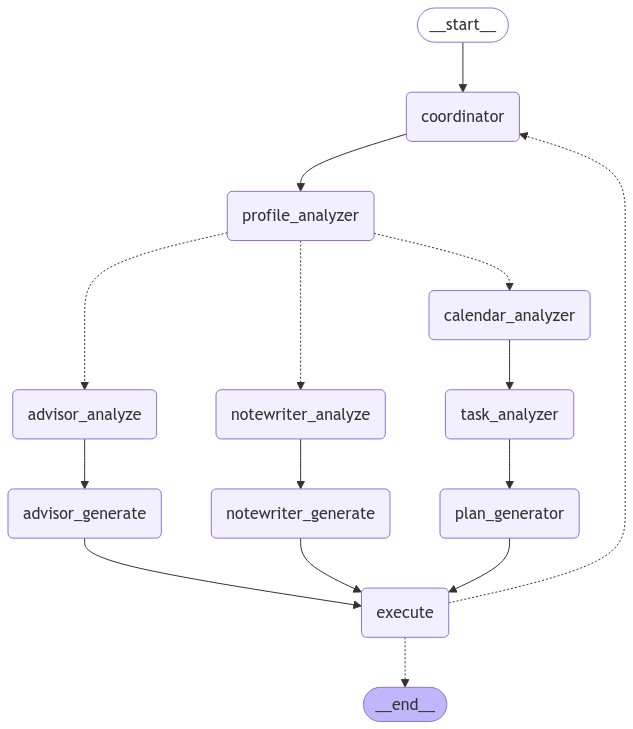

Output()

Coordinator error: Error code: 401 - {'status': 401, 'title': 'Unauthorized', 'detail': 'Authentication failed'}

System error: Error code: 401 - {'status': 401, 'title': 'Unauthorized', 'detail': 'Authentication failed'}

Stack trace:

Traceback (most recent call last):
  File "C:\Users\Ant PC\AppData\Local\Temp\ipykernel_51576\2714013181.py", line 67, in run_all_system
    async for step in graph.astream(state):
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\langgraph\pregel\__init__.py", line 1411, 
in astream
    async for _ in runner.atick(
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\langgraph\pregel\runner.py", line 141, in 
atick
    _panic_or_proceed(all_futures, asyncio.TimeoutError)
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\langgraph\pregel\runner.py", line 186, in 
_panic_or_proceed
    raise exc
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\langgraph\pregel\retry.py", line 79, in 
arun_with_retry
    await task.proc.ainvoke(task.input, task.config)
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\langgraph\utils\runnable.py", line 383, in 
ainvoke
    input = await asyncio.create_task(coro, context=context)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\langgraph\utils\runnable.py", line 168, in 
ainvoke
    ret = await asyncio.create_task(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ant PC\AppData\Local\Temp\ipykernel_51576\553315941.py", line 33, in profile_analyzer
    response = await llm.agenerate(messages)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ant PC\AppData\Local\Temp\ipykernel_51576\2280079859.py", line 67, in agenerate
    completion = await self.client.chat.completions.create(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\openai\resources\chat\completions.py", line
1661, in create
    return await self._post(
           ^^^^^^^^^^^^^^^^^
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\openai\_base_client.py", line 1843, in post
    return await self.request(cast_to, opts, stream=stream, stream_cls=stream_cls)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\openai\_base_client.py", line 1537, in 
request
    return await self._request(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ant PC\AppData\Roaming\pypoetry\venv\Lib\site-packages\openai\_base_client.py", line 1638, in 
_request
    raise self._make_status_error_from_response(err.response) from None
openai.AuthenticationError: Error code: 401 - {'status': 401, 'title': 'Unauthorized', 'detail': 'Authentication 
failed'}

In [22]:
import os
import json

# Assuming the NeMoLLaMa and other necessary classes are already imported

async def load_json_and_test():
    """Load JSON files from local system and run the academic assistance system."""
    print("Academic Assistant Test Setup")
    print("-" * 50)
    
    # Directly specify the file paths for local files
    profile_file = 'profile.json'  # Replace with the actual file path
    calendar_file = 'calendar.json'  # Replace with the actual file path
    task_file = 'task.json'  # Replace with the actual file path
    
    # Define patterns for matching file types (optional, if needed for validation)
    patterns = {
        'profile': r'profile.*\.json$',
        'calendar': r'calendar.*\.json$',
        'task': r'task.*\.json$'
    }

    # Load JSON contents from local files
    try:
        # Check if files exist
        files = {
            'profile': profile_file,
            'calendar': calendar_file,
            'task': task_file
        }

        # Validate that files exist
        missing = [file_type for file_type, file_path in files.items() if not os.path.exists(file_path)]
        if missing:
            print(f"Error: Missing required files: {missing}")
            return

        print("\nFiles found:")
        for file_type, file_path in files.items():
            print(f"- {file_type}: {file_path}")
        
        # Load JSON contents into dictionaries
        json_contents = {}
        for file_type, file_path in files.items():
            with open(file_path, 'r', encoding='utf-8') as f:
                try:
                    json_contents[file_type] = json.load(f)  # Load JSON as a dictionary
                except Exception as e:
                    print(f"Error reading {file_type} file: {str(e)}")
                    return

        print("\nStarting academic assistance workflow...")

        # Initialize NeMoLLaMa with API key (set environment variable if needed)
        # os.environ["OPENAI_API_KEY"] = "your_nemotron_api_key_here"  # Set your actual API key here
        llm = NeMoLLaMa(NEMOTRON_4_340B_INSTRUCT_KEY)  # You can also pass the key directly: NeMoLLaMa(api_key="your_nemotron_api_key_here")
        
        # Process the files with the system (adjust the run_all_system method as needed)
        # Ensure run_all_system method accepts dictionaries, not strings
        coordinator_output, output = await run_all_system(
            json_contents['profile'],   # Pass as dictionary, not string
            json_contents['calendar'],  # Pass as dictionary, not string
            json_contents['task']       # Pass as dictionary, not string
        )
        return coordinator_output, output

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("\nDetailed error information:")
        import traceback
        print(traceback.format_exc())
        return None, None

# Run the system
coordinator_output, output = await load_json_and_test()
